# Pokémon Classification Comparison with PyTorch

In this notebook we build a Pokémon image classifier using a transfer learning approach on the 7K Pokémon dataset. We compare four model architectures:

- **SimpleCNN**: A basic convolutional network
- **Pretrained ResNet18**: Using ResNet18 as a feature extractor
- **Pretrained DenseNet121**: Using DenseNet121 as a feature extractor
- **Pretrained MobileNetV2**: Using MobileNetV2 as a feature extractor

We then compare their performances on the test set, select the best model, and save it for later use (e.g. in a Streamlit demo).

In [1]:
# Step 1: Import Libraries
import os
import glob
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.models import resnet18, densenet121, mobilenet_v2
from torchvision.models import ResNet18_Weights, DenseNet121_Weights, MobileNet_V2_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
from PIL import Image

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [2]:
# Step 2: Define Configuration and Dataset Paths

# Configuration parameters
BATCH_SIZE = 64
IMG_SIZE = 128  # Resize images to 128x128
EPOCHS = 12

# Path to dataset (update to your PokemonData folder location)
DATASET_DIR = "./PokemonData"

# Get the class names from the subfolder names
labels = sorted(os.listdir(DATASET_DIR))
print(f"Found {len(labels)} classes.")

# Create mapping dictionaries
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Gather image paths and corresponding labels
image_paths = []
image_labels = []

for label in labels:
    folder = os.path.join(DATASET_DIR, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder, file))
            image_labels.append(label_to_idx[label])

print(f"Found {len(image_paths)} images.")

Found 150 classes.
Found 6820 images.


In [3]:
# Step 3: Train-Test Split
X = np.array(image_paths)
y = np.array(image_labels)

# Split into training and test sets (using stratification)
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(train_X)} images")
print(f"Test set: {len(test_X)} images")

Training set: 5456 images
Test set: 1364 images


In [4]:
# Step 4: Define Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 10, IMG_SIZE + 10)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print("Data transforms defined.")

Data transforms defined.


In [5]:
# Step 5: Define the Custom Dataset Class
class PokemonDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx], self.image_paths[idx]

# Create training and test datasets and data loaders
train_dataset = PokemonDataset(train_X, train_y, transform=train_transform)
test_dataset = PokemonDataset(test_X, test_y, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Datasets and DataLoaders are ready.")

Datasets and DataLoaders are ready.


In [6]:
# Step 6: Define Model Architectures

## Simple Convolutional Neural Network
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

## Pretrained ResNet18 (Feature Extraction)
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet18, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

## Pretrained DenseNet121 (Feature Extraction)
class PretrainedDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedDenseNet, self).__init__()
        self.model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

## Pretrained MobileNetV2 (Feature Extraction)
class PretrainedMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedMobileNetV2, self).__init__()
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        for param in self.model.parameters():
            param.requires_grad = False
        # Replace the classifier: MobileNetV2 classifier is typically a Sequential with a Dropout and Linear layer
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, x):
        return self.model(x)

num_classes = len(labels)
models = {
    "SimpleCNN": SimpleCNN(num_classes),
    "ResNet18": PretrainedResNet18(num_classes),
    "DenseNet121": PretrainedDenseNet(num_classes),
    "MobileNetV2": PretrainedMobileNetV2(num_classes)
}

print("Model architectures defined.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ramee/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.9MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ramee/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 14.9MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\ramee/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 29.8MB/s]


Model architectures defined.


In [7]:
# Step 7: Training and Evaluation Function

results = {}
best_model = None
best_acc = 0

def train_and_evaluate(model, name):
    global best_model, best_acc
    model.to(DEVICE)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels, _ in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"[{name}] Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels, _ in test_loader:
            outputs = model(images.to(DEVICE))
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    print(f"Test Accuracy ({name}): {acc * 100:.2f}%")
    print(f"F1 Score ({name}): {f1 * 100:.2f}%")

    global best_acc
    if acc > best_acc:
        best_model = model
        best_acc = acc
        torch.save(model.state_dict(), f"best_model_{name}.pth")
        print(f"Saved best model: best_model_{name}.pth")
    
    # Display sample predictions
    print("Sample Predictions:")
    sample_indices = random.sample(range(len(test_dataset)), 5)
    for idx in sample_indices:
        image, label, path = test_dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE))
            pred = torch.argmax(output, dim=1).item()
        plt.imshow(Image.open(path))
        plt.title(f"True: {idx_to_label[label.item()]}, Pred: {idx_to_label[pred]}")
        plt.axis('off')
        plt.show()
    
    results[name] = acc
    return acc

print("Training and evaluation function defined.")

Training and evaluation function defined.



Training model: SimpleCNN
[SimpleCNN] Epoch 1/12 - Loss: 4.9213
[SimpleCNN] Epoch 2/12 - Loss: 4.1380
[SimpleCNN] Epoch 3/12 - Loss: 3.4432
[SimpleCNN] Epoch 4/12 - Loss: 3.0477
[SimpleCNN] Epoch 5/12 - Loss: 2.8058
[SimpleCNN] Epoch 6/12 - Loss: 2.6446
[SimpleCNN] Epoch 7/12 - Loss: 2.4710
[SimpleCNN] Epoch 8/12 - Loss: 2.3788
[SimpleCNN] Epoch 9/12 - Loss: 2.2780
[SimpleCNN] Epoch 10/12 - Loss: 2.1850
[SimpleCNN] Epoch 11/12 - Loss: 2.1155
[SimpleCNN] Epoch 12/12 - Loss: 2.0542
Test Accuracy (SimpleCNN): 41.72%
F1 Score (SimpleCNN): 39.84%
Saved best model: best_model_SimpleCNN.pth
Sample Predictions:


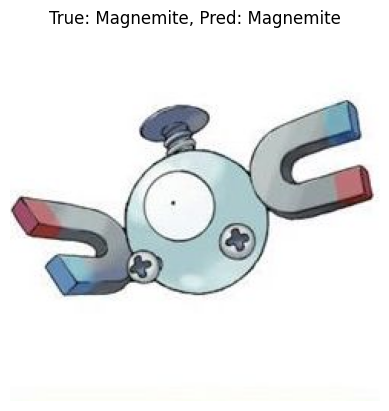

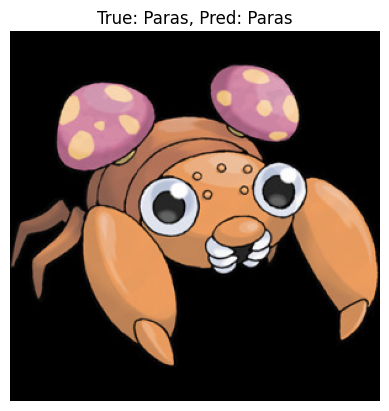

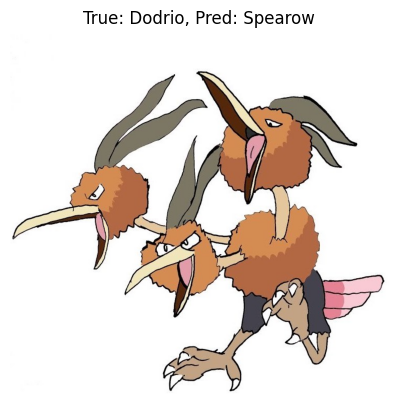

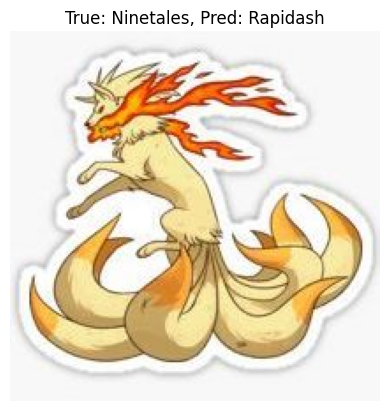

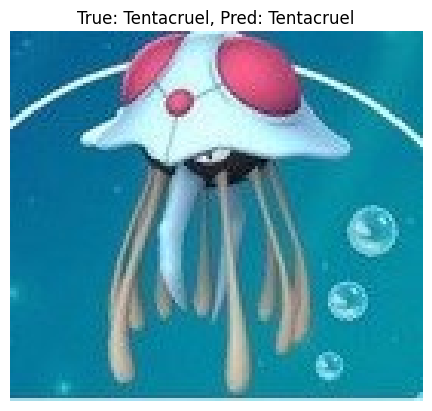


Training model: ResNet18
[ResNet18] Epoch 1/12 - Loss: 4.2161
[ResNet18] Epoch 2/12 - Loss: 2.5207
[ResNet18] Epoch 3/12 - Loss: 1.8426
[ResNet18] Epoch 4/12 - Loss: 1.4900
[ResNet18] Epoch 5/12 - Loss: 1.2738
[ResNet18] Epoch 6/12 - Loss: 1.1063
[ResNet18] Epoch 7/12 - Loss: 1.0330
[ResNet18] Epoch 8/12 - Loss: 0.9482
[ResNet18] Epoch 9/12 - Loss: 0.8573
[ResNet18] Epoch 10/12 - Loss: 0.8163
[ResNet18] Epoch 11/12 - Loss: 0.7662
[ResNet18] Epoch 12/12 - Loss: 0.7210
Test Accuracy (ResNet18): 68.62%
F1 Score (ResNet18): 68.15%
Saved best model: best_model_ResNet18.pth
Sample Predictions:


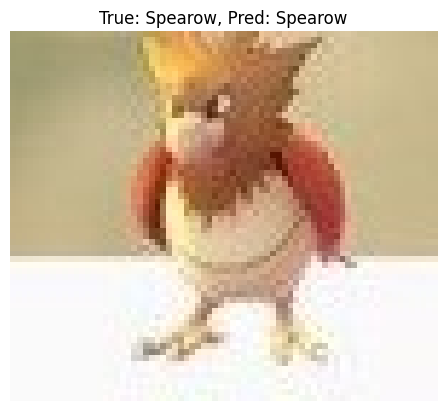

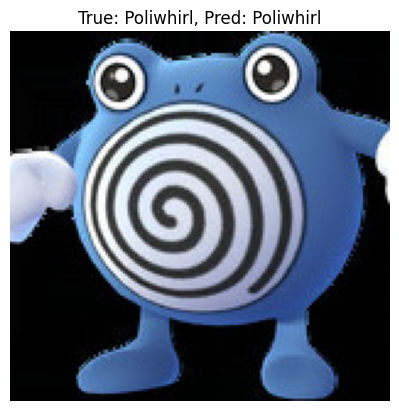

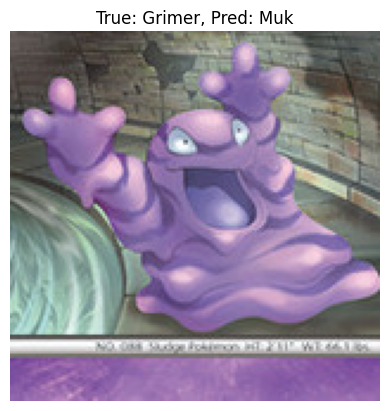

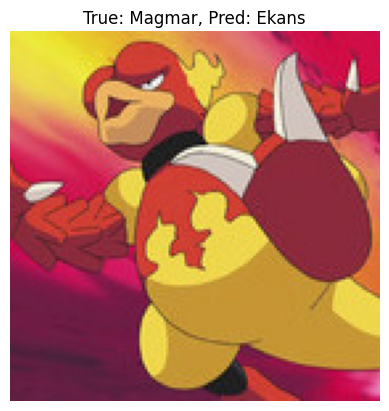

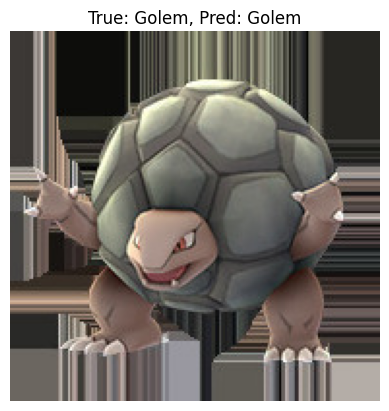


Training model: DenseNet121
[DenseNet121] Epoch 1/12 - Loss: 3.9677
[DenseNet121] Epoch 2/12 - Loss: 2.1173
[DenseNet121] Epoch 3/12 - Loss: 1.4210
[DenseNet121] Epoch 4/12 - Loss: 1.0906
[DenseNet121] Epoch 5/12 - Loss: 0.8788
[DenseNet121] Epoch 6/12 - Loss: 0.7622
[DenseNet121] Epoch 7/12 - Loss: 0.6588
[DenseNet121] Epoch 8/12 - Loss: 0.5941
[DenseNet121] Epoch 9/12 - Loss: 0.5251
[DenseNet121] Epoch 10/12 - Loss: 0.4856
[DenseNet121] Epoch 11/12 - Loss: 0.4401
[DenseNet121] Epoch 12/12 - Loss: 0.4031
Test Accuracy (DenseNet121): 76.32%
F1 Score (DenseNet121): 76.12%
Saved best model: best_model_DenseNet121.pth
Sample Predictions:


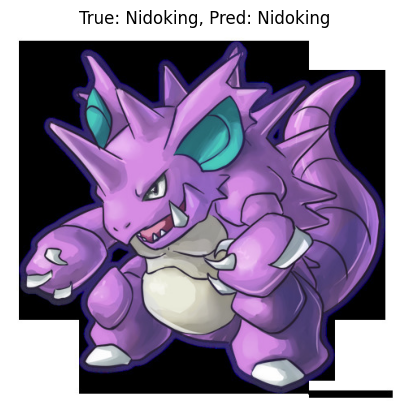

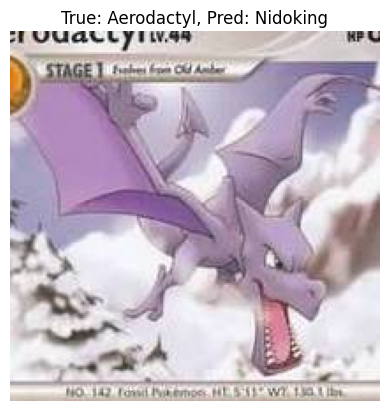

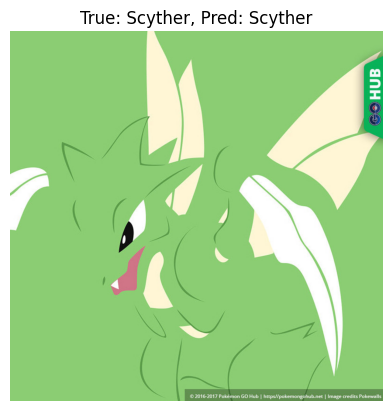

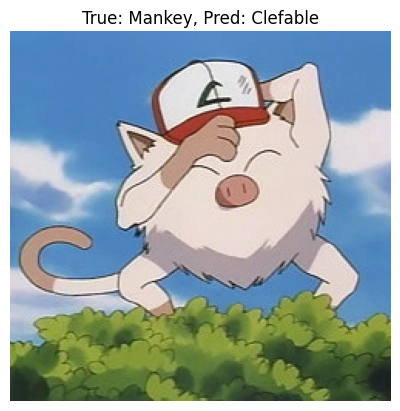

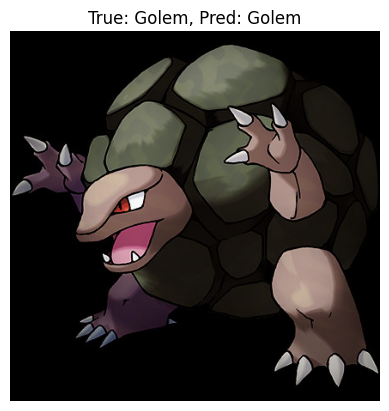


Training model: MobileNetV2
[MobileNetV2] Epoch 1/12 - Loss: 3.9629
[MobileNetV2] Epoch 2/12 - Loss: 2.3245
[MobileNetV2] Epoch 3/12 - Loss: 1.6689
[MobileNetV2] Epoch 4/12 - Loss: 1.3422
[MobileNetV2] Epoch 5/12 - Loss: 1.1422
[MobileNetV2] Epoch 6/12 - Loss: 0.9634
[MobileNetV2] Epoch 7/12 - Loss: 0.8716
[MobileNetV2] Epoch 8/12 - Loss: 0.7815
[MobileNetV2] Epoch 9/12 - Loss: 0.7285
[MobileNetV2] Epoch 10/12 - Loss: 0.6792
[MobileNetV2] Epoch 11/12 - Loss: 0.6157
[MobileNetV2] Epoch 12/12 - Loss: 0.5825
Test Accuracy (MobileNetV2): 71.55%
F1 Score (MobileNetV2): 71.13%
Sample Predictions:


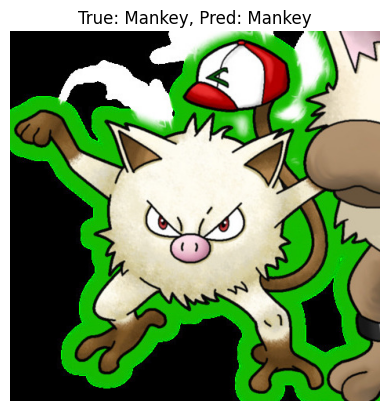

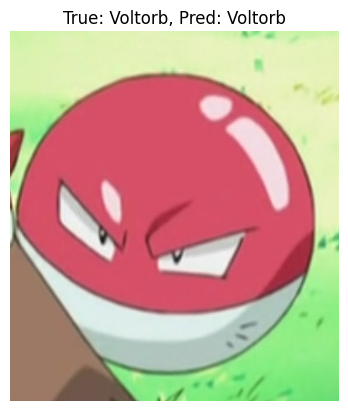

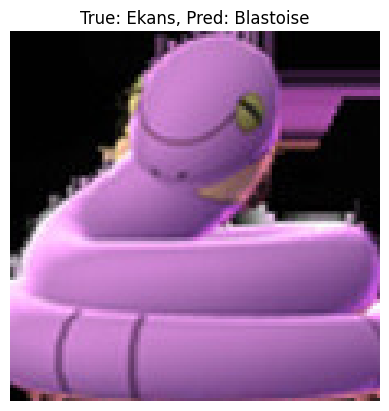

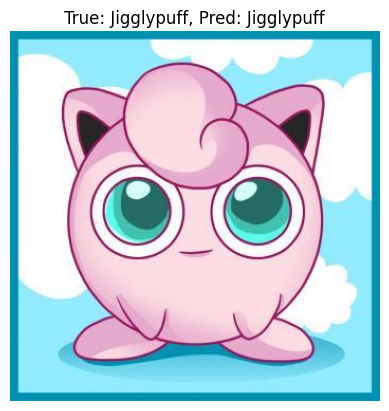

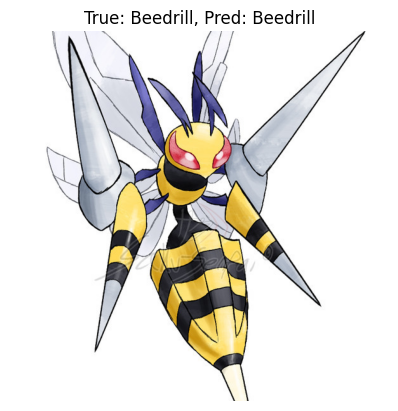


Model training complete.


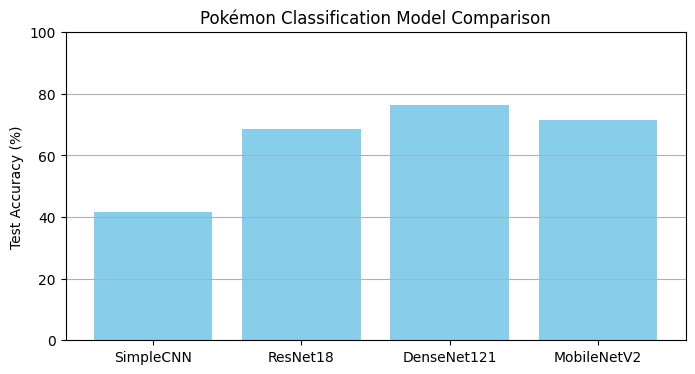

Best model achieved an accuracy of 76.32% and is saved for later use.


In [8]:
# Step 8: Train Each Model and Compare Their Performances
for name, model in models.items():
    print(f"\nTraining model: {name}")
    train_and_evaluate(model, name)

print("\nModel training complete.")

# Visualize the results
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), [v * 100 for v in results.values()], color='skyblue')
plt.ylabel('Test Accuracy (%)')
plt.title('Pokémon Classification Model Comparison')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

print(f"Best model achieved an accuracy of {best_acc * 100:.2f}% and is saved for later use.")